In [1]:
from parsing import *
from database_functions import *
from ml_functions import *

In [ ]:
#pt_featurelist = ['patient_deid', 'examId', 'Gender', 'AgeAtExam']
#patients, appointments, weather = parsing(data_raw_fname = '/Users/jenniferpolson/Documents/School/2017-F/BE 223A/Final Project/Functionalize/be223a_dataset_full.csv', 
#             encoding = "ISO-8859-1", 
#             dtformat = '%Y-%m-%d %H:%M:%S', 
#             pt_featurelist = pt_featurelist)

In [2]:
data_raw_fname = '/Users/jenniferpolson/Documents/School/2017-F/BE 223A/Midterm Project/be223a_dataset.csv'
encoding=None
dtformat='%m/%d/%y %H:%M'
patients, appointments, weather = parsing(data_raw_fname, encoding, dtformat, 
                                          exam_id = 'Exam ID', pt_id = 'Patient ID', age = 'Age', gender = 'Gender')

Reading /Users/jenniferpolson/Documents/School/2017-F/BE 223A/Midterm Project/be223a_dataset.csv
Processed in 3.542 seconds.


In [3]:
patients.rename(columns={'Patient ID':'Patient_ID'}, inplace=True)
appointments.rename(columns={'Exam ID':'Exam_ID', 'Patient ID':'Patient_ID', 'ICD Group': 'ICD_Group'}, inplace=True)

## This is where the DB goes

In [4]:
def generate_string(tablename, df, primarykey, foreignkey):
    
    """ Function to generate the SQL command as a string. This function can be used when only primary keys have to be created and there are no foreign keys associated.
    
    Arguments:
    tablename (char): Name of the table to be created in the database
    df (dataframe): Parsed dataframe output from which field names for the database will be extracted from the column names
    primarykey (char): Primary unique key associated with the table, this should be one of the columnnames from the dataframe
       
    
    Returns:
    An SQL command as a string which can be executed to create tables
    
    """
    
    columnnames=list(df.columns.values)
    columnnames=[item for item in columnnames if item not in foreignkey]
    
    sql_string="CREATE TABLE IF NOT EXISTS"+ " "+ tablename + "("
    
 
        
    for i in range(len(columnnames)):

        if i==len(columnnames)-1:
            col=columnnames[i]
            col_type=df[columnnames[i]].dtype

            if col==primarykey:
                coltype=type_col(col_type)
                sql_string = sql_string + col + " " + coltype + " " + "PRIMARY KEY" + " " + ")" + ";" 
            else:
                coltype=type_col(col_type)
                sql_string= sql_string + col + " " + coltype + " " + ")" + ";"

        else:

            col=columnnames[i]
            col_type=df[columnnames[i]].dtype

            if col==primarykey:
                coltype=type_col(col_type)
                sql_string = sql_string + col + " " + coltype + " " + "PRIMARY KEY" + ","

            else:
                coltype=type_col(col_type)
                sql_string= sql_string + col + " " + coltype + ","

    return (sql_string)

def create_key(database, foreignstring):
    connection = sqlite3.connect(database)
    cursor=connection.cursor()
    cursor.execute(foreignstring)
    connection.commit()
    connection.close()

In [5]:
#Input Parameters
dbname = "223ADB3.db"
patient_key = "Patient_ID"
appointment_key = "Exam_ID"
weather_key = "Dayofyear"

In [6]:
connection = new_connection(dbname)

In [7]:
#Generating SQL Strings
patients_string=generate_string("patients", patients , patient_key, [])
appointments_string=generate_string("appointments", appointments, appointment_key, [patient_key, weather_key])
weather_string=generate_string("weather", weather, "Dayofyear", [])

In [8]:
# Creating tables

create_table(dbname, patients_string)
create_table(dbname, appointments_string)
create_table(dbname, weather_string)

In [9]:
# Creating foreign keys

fkey1=foreignkey("appointments", patient_key, "patients", patient_key)
fkey2=foreignkey("appointments", weather_key, "weather", weather_key)


# Creating foreign key columns
#create_key(dbname, fkey1)
#create_key(dbname, fkey2)

In [10]:
# Push dataframe into database

push_dataframe(patients,dbname, "patients")
push_dataframe(appointments, dbname, "appointments")
push_dataframe(weather,dbname, "weather")

In [11]:
#other function: pull from DB, rearrange to data output
patients = query_data(dbname, "SELECT * from patients") 
appointments = query_data(dbname, "SELECT * from appointments")
weather = query_data(dbname, "SELECT * from weather")

## Start here for merging

In [13]:
df = create_df(appointments, patients, weather, 'Patient_ID', 'Dayofyear').drop('index', axis = 1)

Preprocessing Completed in 33.279 seconds.
GridSearch was not run. Default parameters selected:
- Class Weight: balanced
- Criterion: entropy
- Maximum Features: 0.8
- Number of Estimators: 50
Running the Random Forest Classifier.
Random Forest Classifier Model run in 93.214 seconds.


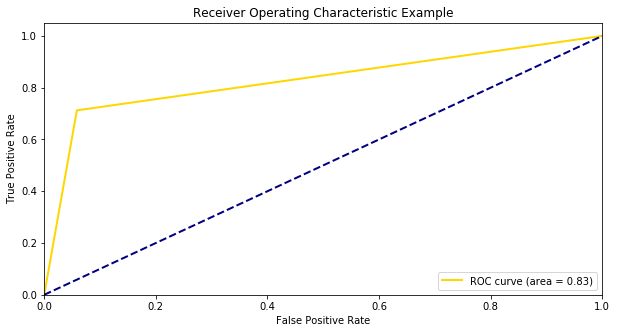

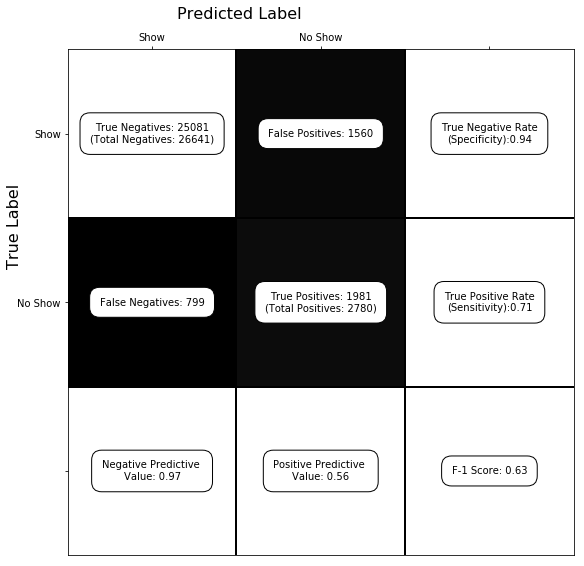

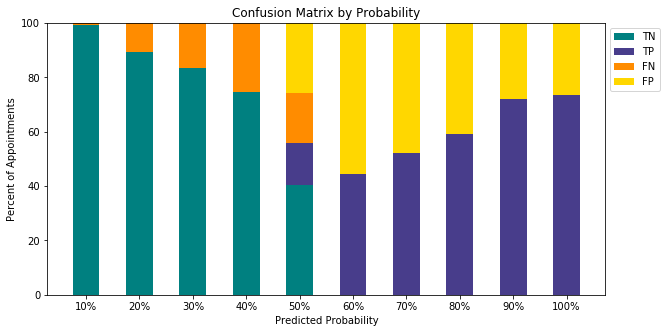

Model Analysis processed in 0.307 seconds.
Pipeline completed in 127.411 seconds.


In [14]:
#run ML
results, test, prob, groups, evalstats = run_model(df, k = 5000, gridsearch = False)

In [15]:
#create new table
results_string = generate_string ('results', results, 'Patient_ID', []) #patient ID
create_table(dbname, results_string)

#push the data to the table
push_dataframe(results,dbname, 'results')

In [16]:
#circular - to make sure it actually worked
#results = query_data(dbname, "SELECT * from results") 

,index,Probabilities,Predictions,Exam_ID
0,104085,0.00,0,8735470
1,7050,0.00,0,8775097
2,88869,0.00,0,8617860
3,3116,0.70,1,8658387
4,36224,0.00,0,8687879
5,142610,0.00,0,8726598
6,137524,0.10,0,8732453
7,72730,0.00,0,8695157
8,18733,0.16,0,8628286
9,99610,0.00,0,8781930
